In [ ]:
# Mount Google Drive to access/save files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Extracting /content/drive/MyDrive/emotiondetection/data/fer2013/fer2013.zip to /content/drive/MyDrive/emotiondetection/data/fer2013/extracted_fer2013_data...
Extraction complete.

Loading FER-2013 training data using ImageFolder...
Full Training dataset samples: 28709
Loading FER-2013 test data using ImageFolder...
Test dataset samples: 7178
Training dataset after split: 22967 samples
Validation dataset: 5742 samples

Example images:


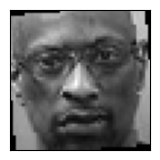

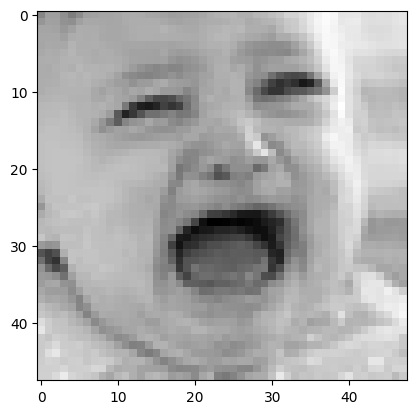

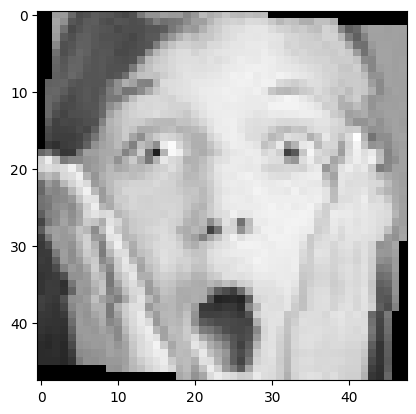

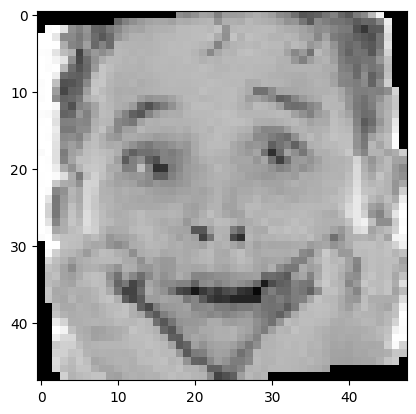

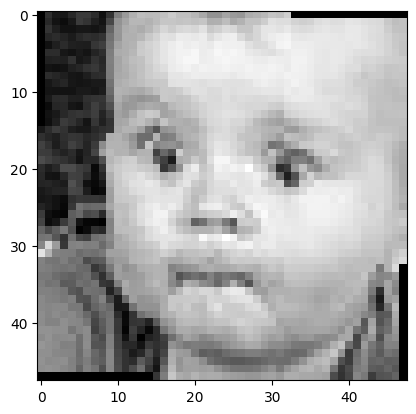

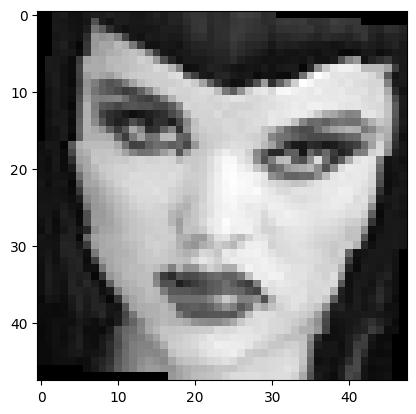

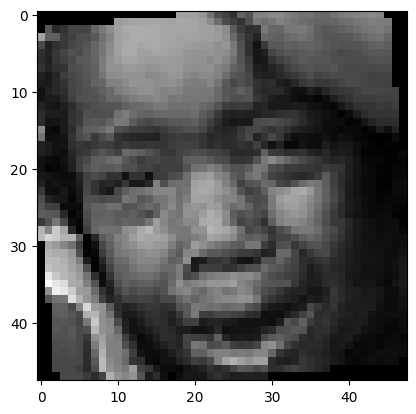

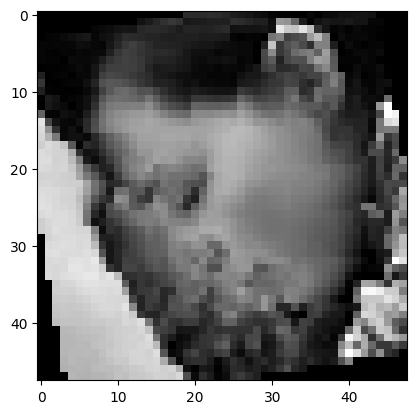

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

# --- Paths for Google Drive and extraction ---

drive_folder = '/content/drive/MyDrive/emotiondetection/data/fer2013'
zip_file_name = 'fer2013.zip'

# Full path to the downloaded zip file in Google Drive
zip_file_path = os.path.join(drive_folder, zip_file_name)

extract_path = os.path.join(drive_folder, 'extracted_fer2013_data')

# --- Extract the dataset if not already extracted ---
if not os.path.exists(extract_path):
    print(f"Extracting {zip_file_path} to {extract_path}...")
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
    except FileNotFoundError:
        print(f"ERROR: '{zip_file_name}' not found at '{zip_file_path}'.")
        print("Please ensure you uploaded 'fer2013.zip' to this exact folder in your Google Drive.")
        print("Stopping execution. Please fix the file path and rerun.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        print("Stopping execution. Please check the zip file or extraction path.")
else:
    print(f"Dataset already extracted to {extract_path}.")


dataset_load_base = extract_path


# --- Define the transformations for the dataset ---
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale
    transforms.RandomHorizontalFlip(),           # Data augmentation
    transforms.RandomRotation(10),               # Data augmentation
    transforms.Resize((48, 48)),                 # Ensure images are 48x48
    transforms.ToTensor(),                       # Convert to PyTorch Tensor (scales to [0, 1])
    transforms.Normalize((0.5,), (0.5,))         # Normalize pixel values to [-1, 1]
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),                 # Ensure images are 48x48
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Neutral', 5: 'Sad', 6: 'Surprise'
}

# --- Load the dataset using torchvision.datasets.ImageFolder ---
print("\nLoading FER-2013 training data using ImageFolder...")
train_full_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_load_base, 'train'),
    transform=transform_train,
)
print(f"Full Training dataset samples: {len(train_full_dataset)}")

print("Loading FER-2013 test data using ImageFolder...")
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(dataset_load_base, 'test'),
    transform=transform_test,
)
print(f"Test dataset samples: {len(test_dataset)}")

#print(f"Detected class names (labels): {train_full_dataset.classes}")

# Split the full training dataset into training and validation sets
train_size = int(0.8 * len(train_full_dataset))
val_size = len(train_full_dataset) - train_size
train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

print(f"Training dataset after split: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Optional: Visualize some samples ---
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    # ImageFolder gives 3 channels for Grayscale if num_output_channels=3, so adjust imshow
    if npimg.shape[0] == 1: # If it's a single channel grayscale image
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    else: # If it's 3 channels (even if grayscale repeated)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print('\nExample images:')
fig = plt.figure(figsize=(10, 4))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    imshow(images[i])
    # Use the classes inferred by ImageFolder for accurate titles
    ax.set_title(train_full_dataset.classes[labels[i].item()])
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define the Convolutional Neural Network (CNN) Model
class EmotdetCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotdetCNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Batch Normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces image size by half (48 -> 24)
        self.dropout1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces image size by half (24 -> 12)
        self.dropout2 = nn.Dropout(0.25)

        # Third convolutional block (optional, but often helpful)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduces image size by half (12 -> 6)
        self.dropout3 = nn.Dropout(0.25)

        # Fully connected layers
        # Calculate the input features for the first linear layer:
        # Image size: 48x48 -> (pool1) 24x24 -> (pool2) 12x12 -> (pool3) 6x6
        # Number of channels after last conv: 256
        self.fc1 = nn.Linear(256 * 6 * 6, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes) # num_classes is 7 for FER-2013

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the feature maps
        x = x.view(x.size(0), -1) # Flatten for fully connected layers

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x) # Output layer (no activation here, as CrossEntropyLoss will apply softmax)
        return x

# Instantiate the model and move it to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotdetCNN(num_classes=7).to(device)

#Print the model architecture to verify
#print(model)

In [ ]:
import torch.optim as optim

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Adam optimizer with learning rate and L2 regularization

# Print them to confirm
#print("\nLoss Function:", criterion)
#print("Optimizer:", optimizer)

In [ ]:
print(device)

cuda


In [ ]:
import time
import copy # For deepcopying best model weights

# --- Training Loop ---
num_epochs = 25 # You can adjust this number

# To keep track of training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
best_model_wts = copy.deepcopy(model.state_dict()) # Initialize with current model weights

print(f"\n--- Starting training for {num_epochs} epochs ---")

for epoch in range(num_epochs):
    start_time = time.time() # To track epoch duration

    # --- Training Phase ---
    model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1) # Get predicted class
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / total_train_samples
    epoch_train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode (disables dropout/batchnorm updates)
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_samples += labels.size(0)
            correct_val_predictions += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val_samples
    epoch_val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Save the best model
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"New best validation accuracy: {best_val_accuracy:.4f}. Saving model weights.")

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch+1}/{num_epochs} - Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}")
    print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_accuracy:.4f}")

print("\nTraining complete!")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Load the best model weights
model.load_state_dict(best_model_wts)
print("Best model weights loaded for final evaluation.")


--- Starting training for 25 epochs ---
New best validation accuracy: 0.4892. Saving model weights.
Epoch 1/25 - Duration: 82.49s
  Train Loss: 1.5531, Train Acc: 0.3969
  Val Loss:   1.3285, Val Acc:   0.4892
New best validation accuracy: 0.5272. Saving model weights.
Epoch 2/25 - Duration: 80.43s
  Train Loss: 1.3134, Train Acc: 0.4968
  Val Loss:   1.2374, Val Acc:   0.5272
New best validation accuracy: 0.5392. Saving model weights.
Epoch 3/25 - Duration: 83.35s
  Train Loss: 1.2362, Train Acc: 0.5281
  Val Loss:   1.2163, Val Acc:   0.5392
New best validation accuracy: 0.5571. Saving model weights.
Epoch 4/25 - Duration: 81.24s
  Train Loss: 1.1784, Train Acc: 0.5520
  Val Loss:   1.1753, Val Acc:   0.5571
New best validation accuracy: 0.5705. Saving model weights.
Epoch 5/25 - Duration: 85.77s
  Train Loss: 1.1425, Train Acc: 0.5677
  Val Loss:   1.1353, Val Acc:   0.5705
New best validation accuracy: 0.5815. Saving model weights.
Epoch 6/25 - Duration: 83.31s
  Train Loss: 1.111


--- Evaluating model on the Test Set ---
Final Test Accuracy: 0.6553

Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.56      0.57       958
     Disgust       0.67      0.50      0.58       111
        Fear       0.55      0.40      0.47      1024
       Happy       0.83      0.88      0.85      1774
     Neutral       0.56      0.69      0.62      1233
         Sad       0.54      0.51      0.52      1247
    Surprise       0.77      0.79      0.78       831

    accuracy                           0.66      7178
   macro avg       0.64      0.62      0.63      7178
weighted avg       0.65      0.66      0.65      7178



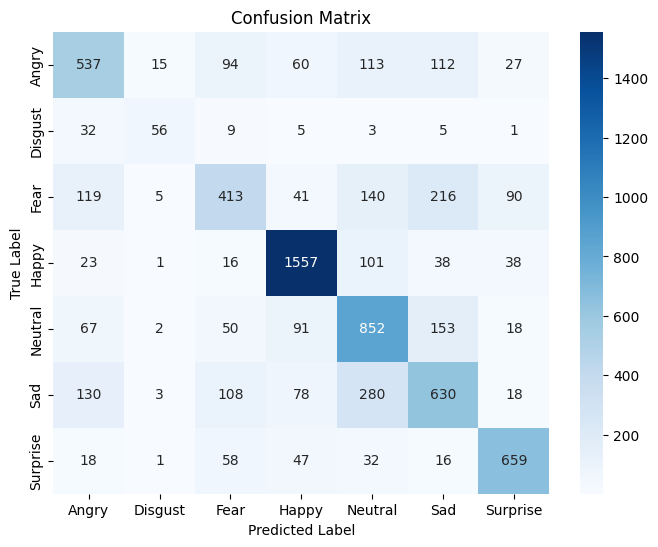

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Evaluating model on the Test Set ---")

model.eval() # Set model to evaluation mode
correct_test_predictions = 0
total_test_samples = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_test_samples += labels.size(0)
        correct_test_predictions += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct_test_predictions / total_test_samples
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Generate and print classification report
print("\nClassification Report:")
target_names = [emotion_labels[i] for i in sorted(emotion_labels.keys())]
print(classification_report(all_labels, all_predictions, target_names=target_names))

# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

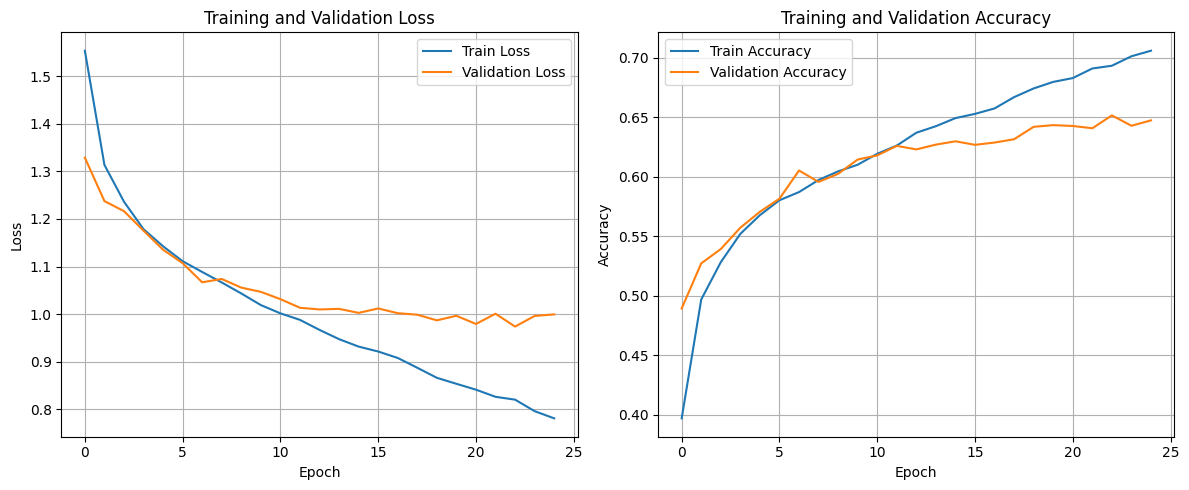

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- Save the trained model ---

model_save_path = '/content/drive/MyDrive/emotiondetection/trainedmodel/emotion_cnn_model.pth'

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the entire model state_dict (best weights were loaded back into 'model' after training)
torch.save(model.state_dict(), model_save_path)

print(f"\nModel saved successfully to: {model_save_path}")


Model saved successfully to: /content/drive/MyDrive/emotiondetection/trainedmodel/emotion_cnn_model.pth
